In [1]:
import os
import sys
import defopt
import pickle
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit
from scipy.stats import wilcoxon
import random
import itertools
import flexiznam as flz
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # save text as text not outlines
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

from cottage_analysis.filepath import generate_filepaths
from cottage_analysis.depth_analysis.depth_preprocess import process_params
from cottage_analysis.analysis import common_utils
# import cottage_analysis as cott
# from cottage_analysis.depth_analysis.filepath.generate_filepaths import *
# from cottage_analysis.imaging.common import find_frames
# from cottage_analysis.imaging.common import imaging_loggers_formatting as format_loggers
# from cottage_analysis.stimulus_structure import sphere_structure as vis_stim_structure
# from cottage_analysis.depth_analysis.plotting.plotting_utils import *
# from cottage_analysis.depth_analysis.plotting.basic_vis_plots import *
# from cottage_analysis.depth_analysis.depth_preprocess.process_params import *
# from cottage_analysis.depth_analysis.depth_preprocess.process_trace import *

In [3]:
project = 'hey2_3d-vision_foodres_20220101'
mouse = 'PZAH8.2f'
session = 'S20230206'

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
original_gaussian_depth_path = '/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_foodres_20220101/PZAG3.4f/S20220520/SpheresPermTubeReward/plane0/gaussian_blob_crossval/gaussian_depth_tuning_fit_new_0.5.pickle'
original_gaussian_blob_path =  '/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_foodres_20220101/PZAG3.4f/S20220520/SpheresPermTubeReward/plane0/gaussian_blob_crossval/gaussian_blob_fit_new_0.1.pickle'
with open(original_gaussian_depth_path, "rb") as handle:
    original_gaussian_depth_df = pickle.load(handle)
with open(original_gaussian_blob_path, "rb") as handle:
    original_gaussian_blob_df = pickle.load(handle)
results = pd.DataFrame(
    columns=['ROI', 'preferred_depth_idx', 'preferred_depth_max', 'preferred_depth', 'log_amplitude', 'xo_logged', 'yo_logged', 'log_sigma_x2', 'log_sigma_y2',
            'theta', 'offset', 'r_sq'])
depth_list=[0.06, 0.19, 0.6, 1.9, 6]
results.ROI = original_gaussian_blob_df.ROI
results.preferred_depth_idx = original_gaussian_blob_df.preferred_depth_idx
for i in range(len(results)):
    results.preferred_depth_max[i] = np.array(depth_list[int(results.preferred_depth_idx.values[i])]) * 100
results.preferred_depth = np.exp(original_gaussian_depth_df.x0_logged.astype('float32'))
results.iloc[:,4:] = original_gaussian_blob_df.iloc[:,2:]
with open('/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_foodres_20220101/PZAG3.4f/S20220520/SpheresPermTubeReward/plane0/gaussian_blob_crossval/gaussian_blob_fit_0.1.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-24-a84280bd380e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.preferred_depth_max[i] = np.array(depth_list[int(results.preferred_depth_idx.values[i])]) * 100


In [12]:
# ----- FUNCS -----

MIN_SIGMA=0.5

def gaussian_func(x, a, x0, log_sigma,b):
    a = a
    sigma = np.exp(log_sigma)+MIN_SIGMA
    return (a * np.exp(-(x - x0) ** 2) / (2 * sigma ** 2))+b


MIN_SIGMA_blob=0.1
def twoD_Gaussian(xy_tuple, log_amplitude, xo, yo, log_sigma_x2, log_sigma_y2, theta, offset):
    (x,y) = xy_tuple
    sigma_x_sq = np.exp(log_sigma_x2) + MIN_SIGMA_blob # 0.25
    sigma_y_sq = np.exp(log_sigma_y2) + MIN_SIGMA_blob  # 0.25
    amplitude = np.exp(log_amplitude)
    a = (np.cos(theta)**2)/(2*sigma_x_sq) + (np.sin(theta)**2)/(2*sigma_y_sq)
    b = (np.sin(2*theta))/(4*sigma_x_sq) - (np.sin(2*theta))/(4*sigma_y_sq)
    c = (np.sin(theta)**2)/(2*sigma_x_sq) + (np.cos(theta)**2)/(2*sigma_y_sq)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                            +c*((y-yo)**2)))
    return g

def gaussian_blob_fit_crossval(project, mouse, session):
    """
    :param str project: project name (determines the root directory for raw data)
    :param str mouse: mouse name
    :param str session: session name,Sdate
    :return: None
    """
    # ----- SETUPS -----
    frame_rate = 15
    speed_thr_cal = 0.2  # m/s, threshold for running speed when calculating depth neurons
    speed_thr = 0.01  #m/s
    depth_min = 2
    depth_max = 2000
    rs_min = 0.5
    rs_max = 500
    of_min = 0.03
    of_max = 3000
    batch_num = 1

    # ----- PATHS -----
    flexilims_session = flz.get_flexilims_session(project_id=project)
    sess_children = generate_filepaths.get_session_children(project=project, mouse=mouse, session=session, flexilims_session=flexilims_session)
    if len(sess_children[sess_children.name.str.contains('Playback')])>0:
        protocols = ['SpheresPermTubeReward','SpheresPermTubeRewardPlayback']
    else:
        protocols = ['SpheresPermTubeReward']
    root = Path(flz.PARAMETERS["data_root"]["processed"])

    # Only do this for closed loop
    for protocol in [protocols[0]]:
        print(f'---------Process protocol {protocol}/{len(protocols)}---------', flush=True)
        print('---STEP 1: Load files...---', '\n', flush=True)
        # ----- STEP1: Generate file path -----
        session_protocol_folder = root/project/mouse/session/protocol
        session_analysis_folder = session_protocol_folder
        session_analysis_folder_old_original = root/project/'Analysis'/mouse/session/protocols[0]
        (
        _,
        _,
        _,
        suite2p_folder,
        _,
        ) = generate_filepaths.generate_file_folders(
            project=project,
            mouse=mouse,
            session=session,
            protocol=protocol,
            all_protocol_recording_entries=None, 
            recording_no=0, 
            flexilims_session=None
        )
        
        save_prefix = 'plane0/gaussian_blob_crossval'
        save_folder = session_analysis_folder/save_prefix
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
            
            
        # Load suite2p files
        ops = np.load(suite2p_folder/'ops.npy', allow_pickle=True)
        ops = ops.item()
        iscell = np.load(suite2p_folder/'iscell.npy', allow_pickle=True)[:, 0]
        
        # All_rois
        which_rois = (np.arange(iscell.shape[0]))[iscell.astype('bool')]

        with open(session_protocol_folder/"plane0/img_VS_all.pickle", "rb") as handle:
            img_VS_all = pickle.load(handle)
        with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "rb") as handle:
            stim_dict_all = pickle.load(handle)
        dffs_ast_all = np.load(session_protocol_folder/"plane0/dffs_ast_all.npy")
        
        depth_neurons = np.load(session_analysis_folder_old_original/"plane0/depth_neurons.npy")
        max_depths = np.load(session_analysis_folder_old_original/"plane0/max_depths_index.npy")

        depth_list = img_VS_all["Depth"].unique()
        depth_list = np.round(depth_list, 2)
        depth_list = depth_list[~np.isnan(depth_list)].tolist()
        depth_list.remove(-99.99)
        depth_list.sort()
        if len(depth_list)==5:
            depth_list=[0.06, 0.19, 0.6, 1.9, 6]
        
        # cmap = cm.cool.reversed()
        # line_colors = []
        # norm = matplotlib.colors.Normalize(vmin=np.log(min(depth_list)), vmax=np.log(max(depth_list)))
        # for depth in depth_list:
        #     rgba_color = cmap(norm(np.log(depth)),bytes=True)
        #     rgba_color = tuple(it/255 for it in rgba_color)
        #     line_colors.append(rgba_color)
                
        print('---STEP 1 FINISHED.---', '\n', flush=True)
    
        # fit gaussian depth
        print('---START STEP 2---', '\n', 'Closed loop - Fit gaussian depth tuning...', flush=True)
        print('MIN SIGMA', str(MIN_SIGMA), flush=True)
        gaussian_depth_fit_df = pd.DataFrame(columns=['ROI', 'preferred_depth_idx', 'a', 'x0_logged', 'log_sigma', 'b','r_sq'])
        gaussian_depth_fit_df.ROI = depth_neurons
        gaussian_depth_fit_df.preferred_depth_idx = max_depths
        speeds = img_VS_all.MouseZ.diff() / img_VS_all.HarpTime.diff()  # m/s
        speeds[0] = 0
        # speed_thr = 0.01
        # speeds_thred = thr(speeds, speed_thr)
        speed_arr, _ = process_params.create_speed_arr(
            speeds=speeds,
            depth_list=depth_list,
            stim_dict=stim_dict_all,
            mode="sort_by_depth",
            protocol="fix_length",
            blank_period=0,
            frame_rate=frame_rate,
        )
        (ndepths, ntrials, nframes) = speed_arr.shape
        
        # Generate list of trials half and half, one half for Gaussian depth fitting, one half for RSOF blob fitting
        np.random.seed(int(session[1:]))
        trial_list1 = np.random.choice(int(ntrials),int(ntrials//2), replace=False)
        trial_list2 = np.array([i for i in np.arange(int(ntrials)) if i not in trial_list1])
        
        gaussian_depth_fit_df = pd.DataFrame(columns=['ROI', 'preferred_depth_max','preferred_depth','a', 'x0_logged', 'log_sigma', 'b','r_sq'])
        gaussian_depth_fit_df.ROI = depth_neurons
        gaussian_depth_fit_df.preferred_depth_idx = max_depths

        for iroi, choose_roi in enumerate(depth_neurons):
            roi = choose_roi
            trace_arr, _ = process_params.create_trace_arr_per_roi(
                which_roi=roi,
                dffs=dffs_ast_all,
                depth_list=depth_list,
                stim_dict=stim_dict_all,
                mode="sort_by_depth",
                protocol="fix_length",
                blank_period=0,
                frame_rate=frame_rate,
            )
            trace_arr_half = trace_arr[:,trial_list1,:]
            speed_arr_half = speed_arr[:,trial_list1,:]
            trace_arr_half[speed_arr_half < speed_thr_cal] = np.nan
            trace_arr_mean_eachtrial_half = np.nanmean(trace_arr_half, axis=2)

            # When open loop, there will be nan values in this array because of low running speed sometimes
            trace_arr_mean_eachtrial_half = np.nan_to_num(trace_arr_mean_eachtrial_half)
            x = np.log(np.repeat(np.array(depth_list) * 100, trace_arr_mean_eachtrial_half.shape[1]))
            roi_number = np.where(depth_neurons == roi)[0][0]
            popt_arr = []
            r_sq_arr = []
            for ibatch in range(batch_num):
                np.random.seed(ibatch)
                p0 = np.concatenate((np.abs(np.random.normal(size=1)),
                                        np.atleast_1d(np.log(np.array(depth_list[int(max_depths[roi_number])]) * 100)),
                                        np.abs(np.random.normal(size=1)),
                                        np.random.normal(size=1))).flatten()
                popt, pcov = curve_fit(gaussian_func, x, trace_arr_mean_eachtrial_half.flatten(),
                                        p0=p0, maxfev=100000,
                                        bounds=(
                                        [0, np.log(depth_min), 0, -np.inf], [np.inf, np.log(depth_max), np.inf, np.inf]))

                y_pred = gaussian_func(x, *popt)
                r_sq = common_utils.calculate_r_squared(trace_arr_mean_eachtrial_half.flatten(), y_pred)
                popt_arr.append(popt)
                r_sq_arr.append(r_sq)
            idx_best = np.argmax(r_sq_arr)
            popt_best = popt_arr[idx_best]
            rsq_best = r_sq_arr[idx_best]

            gaussian_depth_fit_df.iloc[iroi, 3:-1] = popt_best
            gaussian_depth_fit_df.iloc[iroi, -1] = rsq_best
            gaussian_depth_fit_df.loc[iroi, 'preferred_depth_max'] = np.array(depth_list[int(max_depths[roi_number])]) * 100
            gaussian_depth_fit_df.loc[iroi, 'preferred_depth'] = np.exp(popt_best[1])
            preferred_depth_close = gaussian_depth_fit_df.preferred_depth
            preferred_depth_max_close = gaussian_depth_fit_df.preferred_depth_max

            if iroi % 10 == 0:
                print(roi, flush=True)
        save_filename = save_folder/('gaussian_depth_fit_'+str(MIN_SIGMA)+'.pickle')
        with open(save_filename, 'wb') as handle:
            pickle.dump(gaussian_depth_fit_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    
        # For both close loop and open loop --> fit gaussian blob
        print('---START STEP 3---', '\n', 'Fit gaussian depth tuning blob...', flush=True)
        # ----- STEP3: Process params -----
        if 'Playback' in protocol:
            is_actual_running_list = [True, False]
        else:
            is_actual_running_list = [True]
        for is_actual_running in is_actual_running_list:
            if is_actual_running:
                sfx = 'actual_running'
            else:
                sfx = 'virtual_running'
            # Running speed
            # Running speed is thresholded with a small threshold to get rid of non-zero values (default threshold 0.01)
            speeds = img_VS_all.MouseZ.diff() / img_VS_all.HarpTime.diff()  # CHANGE TO MOUSEZ AFTERWARDS!!!
            speeds[0] = 0
            speeds = np.clip(speeds, a_min=speed_thr, a_max=None)
            speed_arr, _ = process_params.create_speed_arr(speeds, depth_list, stim_dict_all, mode='sort_by_depth', protocol='fix_length',
                                                    blank_period=0, frame_rate=frame_rate)
            (ndepths, ntrials, nframes) = speed_arr.shape
            # OF (Unit: rad/s)
            if 'Playback' in protocol:
                speeds_eye = img_VS_all.EyeZ.diff() / img_VS_all.HarpTime.diff()  # EyeZ is how the perspective of animal moves
                speeds_eye[0] = 0
                speeds_eye = np.clip(speeds_eye, a_min=speed_thr, a_max=None)
                speed_eye_arr, _ = process_params.create_speed_arr(speeds_eye, depth_list, stim_dict_all, mode='sort_by_depth', protocol='fix_length',
                                                    blank_period=0, frame_rate=frame_rate)
                optics = process_params.calculate_OF(rs=speeds_eye, img_VS=img_VS_all, mode='no_RF')

            else:
                optics = process_params.calculate_OF(rs=speeds, img_VS=img_VS_all, mode='no_RF')
            of_arr, _ = process_params.create_speed_arr(optics, depth_list, stim_dict_all, mode='sort_by_depth',
                                                protocol='fix_length', blank_period=0,
                                                frame_rate=frame_rate)
            
            if is_actual_running:
                print('Fit actual running speed...', flush=True)
                rs_arr = speed_arr
            else:
                print('Fit virtual running speed...', flush=True)
                rs_arr = speed_eye_arr
            X = rs_arr[:,trial_list2,:].flatten()
            Y = of_arr[:,trial_list2,:].flatten()

            results = pd.DataFrame(
                columns=['ROI', 'preferred_depth_idx', 'preferred_depth_max', 'preferred_depth', 'log_amplitude', 'xo_logged', 'yo_logged', 'log_sigma_x2', 'log_sigma_y2',
                        'theta', 'offset', 'r_sq'])
            results['ROI'] = depth_neurons
            results['preferred_depth_idx'] = max_depths
            results['preferred_depth'] = preferred_depth_close
            results['preferred_depth_max'] = preferred_depth_max_close
            

            # Loop through all rois
            for iroi, choose_roi in enumerate(depth_neurons):
                roi = choose_roi
                trace_arr, _ = process_params.create_trace_arr_per_roi(roi, dffs_ast_all, depth_list, stim_dict_all, mode='sort_by_depth',
                                                                protocol='fix_length', blank_period=0, frame_rate=frame_rate)
                Z = trace_arr[:,trial_list2,:].flatten()

                Z_ = Z[~np.isnan(Z)]
                X_ = X[~np.isnan(Z)]
                Y_ = Y[~np.isnan(Z)]
                log_X_ = np.log(X_ * 100)
                log_Y_ = np.log(np.degrees(Y_))
                popt_arr = []
                rsq_arr = []
                for ibatch in range(batch_num):
                    mu0 = 0
                    sigma0 = 1

                    p0 = np.concatenate((np.random.normal(mu0, sigma0, size=1),
                                            np.atleast_1d(
                                                np.min([np.abs(np.random.normal(mu0, sigma0, size=1)), np.log(rs_min)])),
                                            np.atleast_1d(
                                                [np.min([np.abs(np.random.normal(mu0, sigma0, size=1)) + np.log(of_min)])]),
                                            np.random.normal(mu0, sigma0, size=2),
                                            np.atleast_1d(
                                                np.max([np.abs(np.random.normal(mu0, sigma0, size=1)), np.radians(90)])),
                                            np.random.normal(mu0, sigma0, size=1)))
                    popt, pcov = curve_fit(twoD_Gaussian, (log_X_, log_Y_), Z_, maxfev=100000,
                                            bounds=([-np.inf, np.log(rs_min), np.log(of_min), -np.inf, -np.inf, 0, -np.inf],
                                                    [np.inf, np.log(rs_max), np.log(of_max), np.inf, np.inf, np.radians(90),
                                                    np.inf])
                                            )

                    Z_fit_ = twoD_Gaussian(np.array([log_X_, log_Y_]), *popt)
                    Z_fit = np.empty(Z.shape)
                    Z_fit[:] = np.NaN
                    Z_fit[~np.isnan(Z)] = Z_fit_
                    mse = np.mean((Z_fit_ - Z_) ** 2)
                    r_sq = common_utils.calculate_r_squared(Z_, Z_fit_)
                    popt_arr.append(popt)
                    rsq_arr.append(r_sq)
                idx_best = np.argmax(np.array(rsq_arr))
                popt_best = popt_arr[idx_best]
                Z_fit_best_ = twoD_Gaussian(np.array([log_X_, log_Y_]), *popt_best)
                Z_fit_best = np.empty(Z.shape)
                Z_fit_best[:] = np.NaN
                Z_fit_best[~np.isnan(Z)] = Z_fit_best_
                mse = np.mean((Z_fit_best_ - Z_) ** 2)
                r_sq_best = common_utils.calculate_r_squared(Z_, Z_fit_best_)

                results.iloc[iroi, 4:-1] = popt_best
                results.iloc[iroi, -1] = r_sq_best
                # print(str(roi), np.round(np.exp(popt_best[1:3]),2), flush=True)
                if iroi % 10 == 0:
                    print(roi, flush=True)
                iroi += 1
                

            save_filename = save_folder/('gaussian_blob_fit_'+str(MIN_SIGMA_blob)+'_'+sfx+'.pickle')
            with open(save_filename, 'wb') as handle:
                pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

        

    
    

    
    
    

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
gaussian_blob_fit_crossval(project,mouse,session)

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---------Process protocol SpheresPermTubeReward/2---------
---STEP 1: Load files...--- 



/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/filepath/generate_filepaths.py:160: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/filepath/generate_filepaths.py:165: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/filepath/generate_filepaths.py:90: UserWarning: all_protocol_recording_entries not given, assume only one recording for protocol SpheresPermTubeReward in this session.
             The last recording that matches this protocoll will be returned.
  warn(


---STEP 1 FINISHED.--- 

---START STEP 2--- 
 Closed loop - Fit gaussian depth tuning...
MIN SIGMA 0.5
0


<ipython-input-12-fd2d4f2960ff>:144: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  gaussian_depth_fit_df.preferred_depth_idx = max_depths


13
25
48
69
89
117
134
186
251
295
349
418
617
759
907
1198
1523
1811
2129
2459
2682
3090
---START STEP 3--- 
 Fit gaussian depth tuning blob...
Fit actual running speed...


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0
13
25
48
69
89
117
134
186
251
295
349
418
617
759
907
1198
1523
1811
2129
2459
2682
3090
---------Process protocol SpheresPermTubeRewardPlayback/2---------
---STEP 1: Load files...--- 



/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/filepath/generate_filepaths.py:160: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/filepath/generate_filepaths.py:165: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/filepath/generate_filepaths.py:90: UserWarning: all_protocol_recording_entries not given, assume only one recording for protocol SpheresPermTubeRewardPlayback in this session.
             The last recording that matches this protocoll will be returned.
  warn(


---STEP 1 FINISHED.--- 

---START STEP 2--- 
 Closed loop - Fit gaussian depth tuning...
MIN SIGMA 0.5
0
13
25


<ipython-input-12-fd2d4f2960ff>:161: RuntimeWarning: Mean of empty slice
  trace_arr_mean_eachtrial_half = np.nanmean(trace_arr_half, axis=2)


48
69
89
117
134
186
251
295
349
418
617
759
907
1198
1523
1811
2129
2459
2682
3090
---START STEP 3--- 
 Fit gaussian depth tuning blob...
Fit actual running speed...
0
13
25
48


<ipython-input-12-fd2d4f2960ff>:14: RuntimeWarning: overflow encountered in exp
  sigma_x_sq = np.exp(log_sigma_x2) + MIN_SIGMA_blob # 0.25


69
89
117


KeyboardInterrupt: 

In [ ]:
plt.scatter(gaussian_depth_fit_df.preferred_depth,np.exp(original_gaussian_depth_df.x0_logged.astype('float32')))
plt.xscale('log')
plt.yscale('log')

In [8]:
speed_arr.shape

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'speed_arr' is not defined

In [18]:
original_gaussian_depth_path = '/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_foodres_20220101/Analysis/PZAH8.2f/S20230206/SpheresPermTubeReward/plane0/gaussian_depth_tuning_fit_new_0.5.pickle'
original_gaussian_blob_path =  '/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_foodres_20220101/Analysis/PZAH8.2f/S20230206/SpheresPermTubeReward/plane0/gaussian_blob_fit_new_0.1_actual_running.pickle'
with open(original_gaussian_depth_path, "rb") as handle:
    original_gaussian_depth_df = pickle.load(handle)
with open(original_gaussian_blob_path, "rb") as handle:
    original_gaussian_blob_df = pickle.load(handle)
original_gaussian_blob_df

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ROI,preferred_depth_idx,preferred_depth_gaussian,log_amplitude,xo_logged,yo_logged,log_sigma_x2,log_sigma_y2,theta,offset,r_sq
0,0,4.0,2000.000000,-0.959436,0.808563,1.069367,0.163077,2.831475,0.0,-0.016229,0.062715
1,1,3.0,34.309858,0.478858,4.444463,4.816468,0.234112,-1.833174,0.810952,0.031101,0.291528
2,2,0.0,5.502508,0.421866,-0.670104,6.317932,-0.363747,94.25433,1.570796,0.019074,0.430932
3,3,7.0,606.515059,-0.531651,2.829225,-3.506558,1.219585,2.272202,0.177069,-0.028572,0.059785
4,4,5.0,262.178027,0.116302,6.214608,3.500877,1.565994,-0.085684,0.703882,0.03876,0.092757
...,...,...,...,...,...,...,...,...,...,...,...
219,3031,4.0,59.652494,-2.903234,-0.692581,4.569547,-3.498986,2.973507,1.362398,0.27227,0.00021
220,3090,0.0,6.332397,-2.538962,1.699276,8.006368,-0.171384,1.882176,0.0,0.083785,0.000998
221,3091,5.0,183.550672,-1.92959,1.484731,1.378214,3.77507,2.307636,1.349118,-0.021058,0.00283
222,3184,4.0,150.613716,-3.557072,-0.693146,3.798763,0.508045,2.189182,1.24634,0.089776,0.000735


In [17]:
new_gaussian_blob_path =  '/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_foodres_20220101/PZAH8.2f/S20230206/SpheresPermTubeReward/plane0/gaussian_blob_crossval/gaussian_blob_fit_0.1_actual_running.pickle'
with open(new_gaussian_blob_path, "rb") as handle:
    new_gaussian_blob_df = pickle.load(handle)
new_gaussian_blob_df

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ROI,preferred_depth_idx,preferred_depth_max,preferred_depth,log_amplitude,xo_logged,yo_logged,log_sigma_x2,log_sigma_y2,theta,offset,r_sq
0,0,4.0,80.0,88.222328,-0.999968,1.097326,-0.090406,0.225209,45.964711,0.130485,-0.014704,0.064186
1,1,3.0,40.0,34.387611,1.014344,6.214608,6.058599,1.670699,-1.656207,0.656003,0.031646,0.272171
2,2,0.0,5.0,5.691952,0.467336,4.478501,6.76566,1.837196,-1.509931,0.718495,0.000166,0.44071
3,3,7.0,640.0,621.833849,-0.528691,2.275777,-3.506558,1.035156,2.434819,0.138645,-0.032313,0.076938
4,4,5.0,160.0,230.37501,0.183334,6.214608,4.628836,2.04315,-0.769925,0.931424,0.046525,0.098873
...,...,...,...,...,...,...,...,...,...,...,...,...
219,3031,4.0,80.0,57.440188,0.415305,1.208349,-0.093214,7.303321,4.37005,1.287963,-1.207424,0.000346
220,3090,0.0,5.0,8.935325,-2.657022,2.20429,1.455474,-0.759123,-8.123427,0.899641,0.090809,0.000881
221,3091,5.0,160.0,158.343665,-1.912406,1.521396,1.801166,2.748744,4.158767,0.0,-0.026117,0.002335
222,3184,4.0,80.0,152.761234,-3.398971,-0.693147,2.808272,-2.706992,2.774929,1.536569,0.097552,0.001429


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


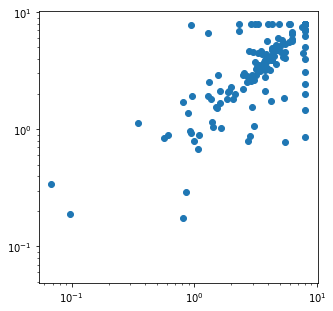

In [23]:
plt.figure(figsize=(5,5))
plt.scatter(original_gaussian_blob_df.yo_logged, new_gaussian_blob_df.yo_logged)
plt.xscale('log')
plt.yscale('log')

In [ ]:
Skip to content

Search or jump to...
Pull requests
Issues
Codespaces
Marketplace
Explore
 
@yiran25 
znamlab
/
cottage_analysis
Internal
Cannot fork because forking is disabled.
Code
Issues
Pull requests
2
Actions
Projects
Wiki
Security
Insights
Commit
Browse the repository at this point in the history
Add new analysis scripts to fit gaussian blob for concatenated sessions
 dev (#7, #3) migrate_depth_analysis (#3)
@yiran25
yiran25 committed on Mar 1 
1 parent d64d062
commit fe58330
Showing 1 changed file with 514 additions and 0 deletions.
 514 changes: 514 additions & 0 deletions514  
cottage_analysis/depth_analysis/analysis/fit_gaussian_blob.py
@@ -0,0 +1,514 @@
from typing import Any

import os
import sys
import defopt
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.optimize import curve_fit
from suite2p.extraction import masks
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # save text as text not outlines
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings


import cottage_analysis as cott
from cottage_analysis.depth_analysis.filepath.generate_filepaths import *
from cottage_analysis.imaging.common import find_frames
from cottage_analysis.imaging.common import imaging_loggers_formatting as format_loggers
from cottage_analysis.stimulus_structure import sphere_structure as vis_stim_structure
from cottage_analysis.depth_analysis.plotting.plotting_utils import *
from cottage_analysis.depth_analysis.depth_preprocess.process_params import *
from cottage_analysis.depth_analysis.depth_preprocess.process_trace import *

from cottage_analysis.io_module import harp

import flexiznam as flz
from pathlib import Path
from warnings import warn
from flexiznam.schema import Dataset


MIN_SIGMA=0.1
def twoD_Gaussian(xy_tuple, log_amplitude, xo, yo, log_sigma_x2, log_sigma_y2, theta, offset):
    (x,y) = xy_tuple
    sigma_x_sq = np.exp(log_sigma_x2) + MIN_SIGMA # 0.25
    sigma_y_sq = np.exp(log_sigma_y2) + MIN_SIGMA  # 0.25
    amplitude = np.exp(log_amplitude)
    a = (np.cos(theta)**2)/(2*sigma_x_sq) + (np.sin(theta)**2)/(2*sigma_y_sq)
    b = (np.sin(2*theta))/(4*sigma_x_sq) - (np.sin(2*theta))/(4*sigma_y_sq)
    c = (np.sin(theta)**2)/(2*sigma_x_sq) + (np.cos(theta)**2)/(2*sigma_y_sq)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                            +c*((y-yo)**2)))
    return g


def gaussian_blob_plotting(roi, speed_arr_noblank, speed_thr, of_arr_noblank, trace_arr_noblank, popt, Z_fit, X, Y, r_sq, Z_, Z_fit_):
    rs_bin_log_min = 0
    rs_bin_log_max = 2.5
    rs_bin_num = 6
    of_bin_log_min = -1.5
    of_bin_log_max = 3.5
    of_bin_num = 11
    log_base = 10

    plt.figure(figsize=(15,5))
    # Heatmap before
    binned_stats = get_binned_stats_2d(xarr1=thr(speed_arr_noblank * 100, speed_thr * 100),
                                       xarr2=np.degrees(of_arr_noblank),
                                       yarr=trace_arr_noblank,
                                       bin_edges=[np.logspace(rs_bin_log_min, rs_bin_log_max,
                                                              num=rs_bin_num, base=log_base)
                                           , np.logspace(of_bin_log_min, of_bin_log_max,
                                                         num=of_bin_num, base=log_base)],
                                       log=True, log_base=log_base)
    vmin = np.nanmin(binned_stats['bin_means'])
    vmax = np.nanmax(binned_stats['bin_means'])
    plt.subplot(141)
    plot_RS_OF_heatmap(binned_stats=binned_stats, log=True, log_base=10,
                       vmin = vmin, vmax = vmax,
                       xlabel='Running Speed (cm/s)', ylabel='Optic Flow (degree/s)')
    plt.title('ROI'+str(roi)+' Original heatmap')

    trace_arr_noblank_fit = Z_fit.reshape(X.shape)
    binned_stats = get_binned_stats_2d(xarr1=thr(speed_arr_noblank * 100, speed_thr * 100),
                                       xarr2=np.degrees(of_arr_noblank),
                                       yarr=trace_arr_noblank_fit,
                                       bin_edges=[np.logspace(rs_bin_log_min, rs_bin_log_max,
                                                              num=rs_bin_num, base=log_base)
                                           , np.logspace(of_bin_log_min, of_bin_log_max,
                                                         num=of_bin_num, base=log_base)],
                                       log=True, log_base=log_base)
    plt.subplot(142)
    plot_RS_OF_heatmap(binned_stats=binned_stats, log=True, log_base=10,
                       vmin = vmin, vmax = vmax,
                       xlabel='Running Speed (cm/s)', ylabel='Optic Flow (degree/s)')
    plt.title(f'Fitted heatmap, theta {np.around(np.degrees(popt[5]))}, \nR2 {np.round(r_sq,3)}')

    # Gaussian kernel
    plt.subplot(143)
    n = 10
    x = np.log(np.logspace(rs_bin_log_min, rs_bin_log_max, num=rs_bin_num * n, base=log_base))
    y = np.log((np.logspace(of_bin_log_min, of_bin_log_max, num=of_bin_num * n, base=log_base)))
    xx_veri, yy_veri = np.meshgrid(x, y)
    z_veri = twoD_Gaussian(np.array([xx_veri.T.flatten(), yy_veri.T.flatten()]), *popt)
    plt.imshow(z_veri.reshape(rs_bin_num * n, of_bin_num * n).T, origin='lower',
               aspect='equal', interpolation=None, cmap='Reds', vmax=vmax)
    plt.colorbar()
    plt.title('Gaussian kernel')
    plt.axis('off')

    # Plot actual vs fit trace
    plt.subplot(144)
    plt.plot(Z_, label='original')
    plt.plot(Z_fit_, label='fitted')
    plt.legend()
    plt.tight_layout(pad=1)


def main(project, mouse, session):
    """
    :param str project: project name (determines the root directory for raw data)
    :param str mouse: mouse name
    :param str session: session name,Sdate
    :return: None
    """
    analysis = True
    plot=True

    flexilims_session = flz.get_flexilims_session(project_id=project)
    sess_children = get_session_children(project=project, mouse=mouse, session=session, flexilims_session=flexilims_session)
    if len(sess_children[sess_children.name.str.contains('Playback')])>0:
        protocols = ['SpheresPermTubeReward','SpheresPermTubeRewardPlayback']
    else:
        protocols = ['SpheresPermTubeReward']
    root = Path(flz.PARAMETERS["data_root"]["processed"])

    # ----- SETUPS -----
    frame_rate = 15
    speed_thr_cal = 0.2  # m/s, threshold for running speed when calculating depth neurons
    # depth_list = [0.06, 0.19, 0.6, 1.9, 6]
    # choose_trials = 50
    speed_thr = 0.01  # m/s

    manual_choose_rois = False
    manually_chosen_rois = [0, 22, 27, 107, 112, 157]

    # fit setup
    rs_min = 0.5
    rs_max = 500
    of_min = 0.03
    of_max = 3000
    batch_num = 5

    for protocol in protocols:
        print(f'---------Process protocol {protocol}/{len(protocols)}---------', flush=True)
        # ----- STEP1: Generate file path -----
        session_analysis_folder_original = root/project/'Analysis'/mouse/session/protocols[0]
        session_protocol_folder = root/project/mouse/session/protocol
        session_analysis_folder = root/project/'Analysis'/mouse/session/protocol
        (
        _,
        _,
        _,
        suite2p_folder,
        _,
        ) = generate_file_folders(
            project=project,
            mouse=mouse,
            session=session,
            protocol=protocol,
            all_protocol_recording_entries=None, 
            recording_no=0, 
            flexilims_session=None
        )

        print('---STEP 1 FINISHED.---', '\n', flush=True)

        # ----- STEP2: Load files -----
        print('---START STEP 2---', '\n', 'Load files...', flush=True)
        # Load suite2p files
        ops = np.load(suite2p_folder/'ops.npy', allow_pickle=True)
        ops = ops.item()
        iscell = np.load(suite2p_folder/'iscell.npy', allow_pickle=True)[:, 0]
        # F = np.load(trace_folder + 'F.npy', allow_pickle=True)
        # Fast = np.load(trace_folder + 'Fast.npy', allow_pickle=True)
        # # Fneu = np.load(trace_folder + 'Fneu.npy', allow_pickle=True)
        # # spks = np.load(trace_folder + 'spks.npy', allow_pickle=True)

        # All_rois
        which_rois = (np.arange(iscell.shape[0]))[iscell.astype('bool')]

        with open(session_protocol_folder/"plane0/img_VS_all.pickle", "rb") as handle:
            img_VS_all = pickle.load(handle)
        with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "rb") as handle:
            stim_dict_all = pickle.load(handle)
        dffs_ast_all = np.load(session_protocol_folder/"plane0/dffs_ast_all.npy")
        depth_neurons = np.load(session_analysis_folder_original/"plane0/depth_neurons.npy")
        max_depths = np.load(session_analysis_folder_original/'plane0/max_depths_index.npy')
        with open(session_analysis_folder/('plane0/gaussian_depth_tuning_fit_new_'+str(0.5)+'.pickle'), 'rb') as handle:
            gaussian_depth_fit_df = pickle.load(handle)

        depth_list = img_VS_all["Depth"].unique()
        depth_list = np.round(depth_list, 2)
        depth_list = depth_list[~np.isnan(depth_list)].tolist()
        depth_list.remove(-99.99)
        depth_list.sort()

        # ----- STEP3: Process params -----
        if 'Playback' in protocol:
            is_actual_running_list = [True, False]
        else:
            is_actual_running_list = [True]
        for is_actual_running in is_actual_running_list:
            print('---START STEP 3---', '\n', 'Process params...', flush=True)
            # Running speed
            # Running speed is thresholded with a small threshold to get rid of non-zero values (default threshold 0.01)
            # speeds = img_VS.MouseZ.diff() / img_VS.HarpTime.diff() # with no playback. EyeZ and MouseZ should be the same.
            speeds = img_VS_all.MouseZ.diff() / img_VS_all.HarpTime.diff()  # CHANGE TO MOUSEZ AFTERWARDS!!!
            speeds[0] = 0
            speeds = thr(speeds, speed_thr)
            # speed_arr, _ = create_speed_arr(speeds, depth_list, stim_dict, mode='sort_by_depth', protocol='fix_length',
            #                                 blank_period=0, frame_rate=frame_rate)
            # speed_arr_mean = np.nanmean(speed_arr, axis=1)
            speed_arr_noblank, _ = create_speed_arr(speeds, depth_list, stim_dict_all, mode='sort_by_depth', protocol='fix_length',
                                                    blank_period=0, frame_rate=frame_rate)
            speed_arr_noblank_mean = np.nanmean(speed_arr_noblank, axis=1)
            speed_arr_blank, _ = create_speed_arr(speeds, depth_list, stim_dict_all, mode='sort_by_depth', protocol='fix_length',
                                                isStim=False, blank_period=0, frame_rate=frame_rate)
            frame_num_pertrial_max = speed_arr_noblank.shape[2]
            total_trials = speed_arr_noblank.shape[1]

            # OF (Unit: rad/s)
            if 'Playback' in protocol:
                speeds_eye = img_VS_all.EyeZ.diff() / img_VS_all.HarpTime.diff()  # EyeZ is how the perspective of animal moves
                speeds_eye[0] = 0
                speeds_eye = thr(speeds_eye, speed_thr)
                speed_eye_arr_noblank, _ = create_speed_arr(speeds_eye, depth_list, stim_dict_all, mode='sort_by_depth', protocol='fix_length',
                                                    blank_period=0, frame_rate=frame_rate)
                optics = calculate_OF(rs=speeds_eye, img_VS=img_VS_all, mode='no_RF')

            else:
                optics = calculate_OF(rs=speeds, img_VS=img_VS_all, mode='no_RF')
            of_arr_noblank, _ = create_speed_arr(optics, depth_list, stim_dict_all, mode='sort_by_depth',
                                                protocol='fix_length', blank_period=0,
                                                frame_rate=frame_rate)
            print('---STEP 3 FINISHED.---', '\n', flush=True)


            # VER 2: FIT 2D GAUSSIAN TO LOG(RS) & LOG(OF) (Without plotting)
            # ----- STEP4: 2D Gaussian fit for dff-RS/OF -----
            # Fit to 2D gaussian, see equations from https://handwiki.org/wiki/Gaussian_function
            print('---START STEP 4---', '\n', 'Fit gaussian blob...', flush=True)
            print('MIN SIGMA', str(MIN_SIGMA), flush=True)
            if is_actual_running:
                print('Fit actual running speed...', flush=True)
                speed_arr = speed_arr_noblank
                X = speed_arr_noblank.flatten()
                sfx = '_actual_running'
            else:
                print('Fit virtual running speed...', flush=True)
                speed_arr = speed_eye_arr_noblank
                X = speed_eye_arr_noblank.flatten()
                sfx = '_virtual_running'
            Y = of_arr_noblank.flatten()

            results = pd.DataFrame(
                columns=['ROI', 'preferred_depth_idx', 'preferred_depth_gaussian', 'log_amplitude', 'xo_logged', 'yo_logged', 'log_sigma_x2', 'log_sigma_y2',
                        'theta', 'offset', 'r_sq'])
            results['ROI'] = depth_neurons
            results['preferred_depth_idx'] = max_depths
            results['preferred_depth_gaussian'] = np.exp(np.array(gaussian_depth_fit_df.x0_logged).astype('float64'))


            # Loop through all rois
            if analysis:
                for iroi, choose_roi in enumerate(depth_neurons):
                    roi = choose_roi
                    trace_arr_noblank, _ = create_trace_arr_per_roi(roi, dffs_ast_all, depth_list, stim_dict_all, mode='sort_by_depth',
                                                                    protocol='fix_length', blank_period=0, frame_rate=frame_rate)
                    Z = trace_arr_noblank.flatten()

                    Z_ = Z[~np.isnan(Z)]
                    X_ = X[~np.isnan(Z)]
                    Y_ = Y[~np.isnan(Z)]
                    log_X_ = np.log(X_ * 100)
                    log_Y_ = np.log(np.degrees(Y_))
                    popt_arr = []
                    rsq_arr = []
                    np.random.seed(42)
                    for ibatch in range(batch_num):
                        mu0 = 0
                        sigma0 = 1

                        p0 = np.concatenate((np.random.normal(mu0, sigma0, size=1),
                                                np.atleast_1d(
                                                    np.min([np.abs(np.random.normal(mu0, sigma0, size=1)), np.log(rs_min)])),
                                                np.atleast_1d(
                                                    [np.min([np.abs(np.random.normal(mu0, sigma0, size=1)) + np.log(of_min)])]),
                                                np.random.normal(mu0, sigma0, size=2),
                                                np.atleast_1d(
                                                    np.max([np.abs(np.random.normal(mu0, sigma0, size=1)), np.radians(90)])),
                                                np.random.normal(mu0, sigma0, size=1)))
                        popt, pcov = curve_fit(twoD_Gaussian, (log_X_, log_Y_), Z_, maxfev=100000,
                                                bounds=([-np.inf, np.log(rs_min), np.log(of_min), -np.inf, -np.inf, 0, -np.inf],
                                                        [np.inf, np.log(rs_max), np.log(of_max), np.inf, np.inf, np.radians(90),
                                                        np.inf])
                                                )

                        Z_fit_ = twoD_Gaussian(np.array([log_X_, log_Y_]), *popt)
                        Z_fit = np.empty(Z.shape)
                        Z_fit[:] = np.NaN
                        Z_fit[~np.isnan(Z)] = Z_fit_
                        mse = np.mean((Z_fit_ - Z_) ** 2)
                        r_sq = calculate_R_squared(Z_, Z_fit_)
                        popt_arr.append(popt)
                        rsq_arr.append(r_sq)
                    idx_best = np.argmax(np.array(rsq_arr))
                    popt_best = popt_arr[idx_best]
                    Z_fit_best_ = twoD_Gaussian(np.array([log_X_, log_Y_]), *popt_best)
                    Z_fit_best = np.empty(Z.shape)
                    Z_fit_best[:] = np.NaN
                    Z_fit_best[~np.isnan(Z)] = Z_fit_best_
                    mse = np.mean((Z_fit_best_ - Z_) ** 2)
                    r_sq_best = calculate_R_squared(Z_, Z_fit_best_)

                    results.iloc[iroi, 3:-1] = popt_best
                    results.iloc[iroi, -1] = r_sq_best
                    # print(str(roi), np.round(np.exp(popt_best[1:3]),2), flush=True)
                    if iroi % 10 == 0:
                        print(roi, flush=True)
                    iroi += 1

                save_filename = session_analysis_folder/('plane0/gaussian_blob_fit_new_'+str(MIN_SIGMA)+sfx+'.pickle')
                with open(save_filename, 'wb') as handle:
                    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print('---STEP 4 FINISHED.---', '\n', flush=True)


    print('---Start plotting.---', '\n', flush=True)
    if plot:
        for protocol in protocols:
            print(f'---------Process protocol {protocol}/{len(protocols)}---------', flush=True)
            # ----- STEP1: Generate file path -----
            session_analysis_folder_original = root/project/'Analysis'/mouse/session/protocols[0]
            session_protocol_folder = root/project/mouse/session/protocol
            session_analysis_folder = root/project/'Analysis'/mouse/session/protocol
            (
            _,
            _,
            _,
            suite2p_folder,
            _,
            ) = generate_file_folders(
                project=project,
                mouse=mouse,
                session=session,
                protocol=protocol,
                all_protocol_recording_entries=None, 
                recording_no=0, 
                flexilims_session=None
            )


            # ----- STEP3: Process params -----
            if 'Playback' in protocol:
                is_actual_running_list = [True, False]
            else:
                is_actual_running_list = [True]
            for is_actual_running in is_actual_running_list:
                # Running speed
                # Running speed is thresholded with a small threshold to get rid of non-zero values (default threshold 0.01)
                # speeds = img_VS.MouseZ.diff() / img_VS.HarpTime.diff() # with no playback. EyeZ and MouseZ should be the same.
                speeds = img_VS_all.MouseZ.diff() / img_VS_all.HarpTime.diff()  # CHANGE TO MOUSEZ AFTERWARDS!!!
                speeds[0] = 0
                speeds = thr(speeds, speed_thr)
                # speed_arr, _ = create_speed_arr(speeds, depth_list, stim_dict, mode='sort_by_depth', protocol='fix_length',
                #                                 blank_period=0, frame_rate=frame_rate)
                # speed_arr_mean = np.nanmean(speed_arr, axis=1)
                speed_arr_noblank, _ = create_speed_arr(speeds, depth_list, stim_dict_all, mode='sort_by_depth', protocol='fix_length',
                                                        blank_period=0, frame_rate=frame_rate)
                speed_arr_noblank_mean = np.nanmean(speed_arr_noblank, axis=1)
                speed_arr_blank, _ = create_speed_arr(speeds, depth_list, stim_dict_all, mode='sort_by_depth', protocol='fix_length',
                                                    isStim=False, blank_period=0, frame_rate=frame_rate)
                frame_num_pertrial_max = speed_arr_noblank.shape[2]
                total_trials = speed_arr_noblank.shape[1]

                # OF (Unit: rad/s)
                if 'Playback' in protocol:
                    speeds_eye = img_VS_all.EyeZ.diff() / img_VS_all.HarpTime.diff()  # EyeZ is how the perspective of animal moves
                    speeds_eye[0] = 0
                    speeds_eye = thr(speeds_eye, speed_thr)
                    speed_eye_arr_noblank, _ = create_speed_arr(speeds_eye, depth_list, stim_dict_all, mode='sort_by_depth', protocol='fix_length',
                                                        blank_period=0, frame_rate=frame_rate)
                    optics = calculate_OF(rs=speeds_eye, img_VS=img_VS_all, mode='no_RF')

                else:
                    optics = calculate_OF(rs=speeds, img_VS=img_VS_all, mode='no_RF')
                of_arr_noblank, _ = create_speed_arr(optics, depth_list, stim_dict_all, mode='sort_by_depth',
                                                    protocol='fix_length', blank_period=0,
                                                    frame_rate=frame_rate)
                if is_actual_running:
                    print('Plot actual running speed...', flush=True)
                    speed_arr = speed_arr_noblank
                    X = speed_arr_noblank.flatten()
                    sfx = '_actual_running'
                else:
                    print('Plot virtual running speed...', flush=True)
                    speed_arr = speed_eye_arr_noblank
                    X = speed_eye_arr_noblank.flatten()
                    sfx = '_virtual_running'
                Y = of_arr_noblank.flatten()

                save_prefix = 'plane0/plots/gaussian_blob_fit_new_'+str(MIN_SIGMA)+sfx+'/'
                if not os.path.exists(session_analysis_folder/save_prefix):
                    os.makedirs(session_analysis_folder/save_prefix)
                with open(session_analysis_folder/('plane0/gaussian_blob_fit_new_'+str(MIN_SIGMA)+sfx+'.pickle'), 'rb') as handle:
                    results = pickle.load(handle)

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    if manual_choose_rois:
                        select_rois = manually_chosen_rois
                        for choose_roi in select_rois:
                            roi = choose_roi
                            trace_arr_noblank, _ = create_trace_arr_per_roi(roi, dffs_ast_all, depth_list, stim_dict_all,
                                                                            mode='sort_by_depth',
                                                                            protocol='fix_length', blank_period=0,
                                                                            frame_rate=frame_rate)
                            Z = trace_arr_noblank.flatten()

                            Z_ = Z[~np.isnan(Z)]
                            X_ = X[~np.isnan(Z)]
                            Y_ = Y[~np.isnan(Z)]
                            log_X_ = np.log(X_ * 100)
                            log_Y_ = np.log(np.degrees(Y_))
                            popt = results[results.ROI==roi].values[0][3:-1]
                            r_sq = results[results.ROI==roi]['r_sq'].values[0]
                            Z_fit_ = twoD_Gaussian(np.array([log_X_, log_Y_]), *popt)
                            Z_fit = np.empty(Z.shape)
                            Z_fit[:] = np.NaN
                            Z_fit[~np.isnan(Z)] = Z_fit_
                            gaussian_blob_plotting(roi=roi, speed_arr_noblank=speed_arr, speed_thr=speed_thr,
                                                    of_arr_noblank=of_arr_noblank, trace_arr_noblank=trace_arr_noblank,
                                                    popt=popt, Z_fit=Z_fit, X=X, Y=Y, r_sq=r_sq, Z_=Z_, Z_fit_=Z_fit_)

                            if not os.path.exists(session_analysis_folder/save_prefix/'examples/'):
                                os.makedirs(session_analysis_folder/save_prefix/'examples/')

                            plt.savefig(session_analysis_folder/save_prefix/('examples/roi' + str(choose_roi) + '.pdf'))
                            print('ROI' + str(choose_roi), flush=True)

                    else:
                        for this_depth in range(len(depth_list)):

                            if not os.path.exists(
                                    session_analysis_folder/save_prefix/('depth' + str(depth_list[this_depth]) + '/')):
                                os.makedirs(session_analysis_folder/save_prefix/('depth' + str(depth_list[this_depth]) + '/'))
                            save_folder = session_analysis_folder/save_prefix/('depth' + str(depth_list[this_depth]) + '/')

                            neurons_this_depth = depth_neurons[max_depths == this_depth]
                            if len(neurons_this_depth) > 0:
                                rois_mins, rois_maxs = segment_arr(np.arange(len(neurons_this_depth)), segment_size=10)
                                for rois_min, rois_max in zip(rois_mins, rois_maxs):
                                    if rois_min != rois_max:
                                        select_rois = np.array(neurons_this_depth[rois_min:rois_max])
                                    else:
                                        select_rois = np.array(neurons_this_depth[rois_min:rois_max + 1])

                                    if len(select_rois) > 1:
                                        pdf_name = save_folder/('roi' + str(select_rois[0]) + '-' + str(
                                            select_rois[-1]) + '.pdf')
                                    elif len(select_rois) == 1:
                                        pdf_name = save_folder/('roi' + str(select_rois) + '.pdf')
                                    with PdfPages(pdf_name) as pdf:

                                        for choose_roi in select_rois:

                                            roi = choose_roi
                                            trace_arr_noblank, _ = create_trace_arr_per_roi(roi, dffs_ast_all, depth_list, stim_dict_all,
                                                                                            mode='sort_by_depth',
                                                                                            protocol='fix_length',
                                                                                            blank_period=0,
                                                                                            frame_rate=frame_rate)
                                            Z = trace_arr_noblank.flatten()

                                            Z_ = Z[~np.isnan(Z)]
                                            X_ = X[~np.isnan(Z)]
                                            Y_ = Y[~np.isnan(Z)]
                                            log_X_ = np.log(X_ * 100)
                                            log_Y_ = np.log(np.degrees(Y_))
                                            popt = results[results.ROI==roi].values[0][3:-1]
                                            r_sq = results[results.ROI == roi]['r_sq'].values[0]
                                            Z_fit_ = twoD_Gaussian(np.array([log_X_, log_Y_]), *popt)
                                            Z_fit = np.empty(Z.shape)
                                            Z_fit[:] = np.NaN
                                            Z_fit[~np.isnan(Z)] = Z_fit_
                                            gaussian_blob_plotting(roi=roi, speed_arr_noblank=speed_arr,
                                                                    speed_thr=speed_thr,
                                                                    of_arr_noblank=of_arr_noblank,
                                                                    trace_arr_noblank=trace_arr_noblank,
                                                                    popt=popt, Z_fit=Z_fit, X=X, Y=Y, r_sq=r_sq, Z_=Z_, Z_fit_=Z_fit_)

                                            pdf.savefig()
                                            plt.close()

                                            print('ROI' + str(choose_roi), flush=True)

            print('Finished plotting.', flush=True)



if __name__ == "__main__":
    defopt.run(main)



0 comments on commit fe58330
@yiran25
 
Add heading textAdd bold text, <Cmd+b>Add italic text, <Cmd+i>
Add a quote, <Cmd+Shift+.>Add code, <Cmd+e>Add a link, <Cmd+k>
Add a bulleted list, <Cmd+Shift+8>Add a numbered list, <Cmd+Shift+7>Add a task list, <Cmd+Shift+l>
Directly mention a user or team
Reference an issue, pull request, or discussion
Add saved reply
Leave a comment
No file chosen
Attach files by dragging & dropping, selecting or pasting them.
Styling with Markdown is supported
 You’re not receiving notifications from this thread.
Footer
© 2023 GitHub, Inc.
Footer navigation
Terms
Privacy
Security
Status
Docs
Contact GitHub
Pricing
API
Training
Blog
About
Add new analysis scripts to fit gaussian blob for concatenated sessions · znamlab/cottage_analysis@fe58330

In [ ]:
"""
main script for basic preprocessing of 2p depth experimental data

For now, use env: 2p_analysis_clone
"""

# IMPORTS
from typing import Any

import os
import sys
import defopt
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.optimize import curve_fit
from suite2p.extraction import masks
import matplotlib
from matplotlib import cm
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # save text as text not outlines
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings


import cottage_analysis as cott
from cottage_analysis.depth_analysis.filepath.generate_filepaths import *
from cottage_analysis.imaging.common import find_frames
from cottage_analysis.imaging.common import imaging_loggers_formatting as format_loggers
from cottage_analysis.stimulus_structure import sphere_structure as vis_stim_structure
from cottage_analysis.depth_analysis.plotting.plotting_utils import *
from cottage_analysis.depth_analysis.plotting.basic_vis_plots import *
from cottage_analysis.depth_analysis.depth_preprocess.process_params import *
from cottage_analysis.depth_analysis.depth_preprocess.process_trace import *

from cottage_analysis.io_module import harp

import flexiznam as flz
from pathlib import Path
from warnings import warn
from flexiznam.schema import Dataset


MIN_SIGMA=0.5

def gaussian_func(x, a, x0, log_sigma,b):
    a = a
    sigma = np.exp(log_sigma)+MIN_SIGMA
    return (a * np.exp(-(x - x0) ** 2) / (2 * sigma ** 2))+b
    
def main(project, mouse, session):
    """
    :param str project: project name (determines the root directory for raw data)
    :param str mouse: mouse name
    :param str session: session name,Sdate
    :return: None
    """

    # ----- SETUPS -----
    flexilims_session = flz.get_flexilims_session(project_id=project)
    sess_children = get_session_children(project=project, mouse=mouse, session=session, flexilims_session=flexilims_session)
    if len(sess_children[sess_children.name.str.contains('Playback')])>0:
        protocols = ['SpheresPermTubeReward','SpheresPermTubeRewardPlayback']
    else:
        protocols = ['SpheresPermTubeReward']
    # rawdata_root = "/camp/lab/znamenskiyp/data/instruments/raw_data/projects/"
    # root = "/camp/lab/znamenskiyp/home/shared/projects/"
    # # depth_list = [0.06, 0.19, 0.6, 1.9, 6]
    frame_rate = 15
    speed_thr_cal = (
        0.2  # m/s, threshold for running speed when calculating depth neurons
    )
    is_calculate_dFF = True
    manual_choose_rois = False
    manually_chosen_rois = [0,1,2,3,4]
    # Fontsizes
    fontsize_dict = {
        'title': 10,
        'xlabel': 12,
        'ylabel': 12,
        'xticks': 10,
        'yticks': 10,
        'legend': 5
    }

    fontsize_dict_heatmap = {
        'title': 10,
        'xlabel': 12,
        'ylabel': 12,
        'xticks': 7,
        'yticks': 7,
        'legend': 5
    }

    for protocol in protocols:
        print(f'---------Process protocol {protocol}/{len(protocols)}---------', flush=True)
        # ----- STEP1: Generate file path -----
        flexilims_session = flz.get_flexilims_session(project_id=project)
        all_protocol_recording_entries = get_all_recording_entries(project, mouse, session, protocol=protocol, flexilims_session=flexilims_session)

        # make folder for this protocol (closedloop/playback)
        root = Path(flz.PARAMETERS["data_root"]["processed"])
        session_protocol_folder = root/project/mouse/session/protocol
        if not os.path.exists(session_protocol_folder/"plane0/"):
            os.makedirs(session_protocol_folder/"plane0/")
        session_analysis_folder = root/project/'Analysis'/mouse/session/protocol
        if not os.path.exists(session_analysis_folder/"plane0/"):
            os.makedirs(session_analysis_folder/"plane0/")
        session_analysis_folder_original = root/project/'Analysis'/mouse/session/protocols[0]
        if not os.path.exists(session_analysis_folder_original/"plane0/"):
            os.makedirs(session_analysis_folder_original/"plane0/")
            
        all_folder_nos = []

        for irecording in range(len(all_protocol_recording_entries)):
            print(f'-----Process recording {irecording+1}/{len(all_protocol_recording_entries)}-----', flush=True)
            print("---START STEP 1---", "\n", "Getting data filepaths...", flush=True)

            (
                rawdata_folder,
                protocol_folder,
                analysis_folder,
                suite2p_folder,
                trace_folder,
            ) = generate_file_folders(
                project=project,
                mouse=mouse,
                session=session,
                protocol=protocol,
                all_protocol_recording_entries=all_protocol_recording_entries, 
                recording_no=irecording, 
                flexilims_session=flexilims_session
            )
            if not os.path.exists(analysis_folder/"plane0/"):
                os.makedirs(analysis_folder/"plane0/")

            if "Playback" in protocol:
                (
                    rawdata_folder_closeloop,
                    protocol_folder_closeloop,
                    analysis_folder_closeloop,
                    suite2p_folder_closeloop,
                    trace_folder_closeloop,
                ) = generate_file_folders(
                    project=project,
                    mouse=mouse,
                    session=session,
                    protocol=protocol.replace("Playback", ""),
                    all_protocol_recording_entries=all_protocol_recording_entries, 
                    recording_no=irecording, 
                    flexilims_session=flexilims_session
                )
                assert os.path.exists(analysis_folder_closeloop/"plane0/")
                
            # Indicate the folder no for suite2p trace to find the frame number of this folder
            sess_children = get_session_children(project=project, mouse=mouse, session=session, flexilims_session=flexilims_session)
            sess_children_protocols = sess_children[sess_children['name'].str.contains('(SpheresPermTubeReward|Fourier|Retinotopy)')]
            folder_no = sess_children_protocols.index.get_loc(sess_children_protocols[sess_children_protocols.id == all_protocol_recording_entries.iloc[irecording].id].index[0])
            all_folder_nos.append(folder_no)
            print("---STEP 1 FINISHED.---", "\n", flush=True)

            # -----STEP2: Calculate dF/F from the raw fluorescence trace and Save -----
            print("---START STEP 2---", "\n", "Calculating dF/F for all ROIs...", flush=True)
            # Load suite2p files
            stat = np.load(suite2p_folder/"stat.npy", allow_pickle=True)
            ops = np.load(suite2p_folder/"ops.npy", allow_pickle=True)
            ops = ops.item()
            stats = np.load(suite2p_folder/"stat.npy", allow_pickle=True)
            iscell = np.load(suite2p_folder/"iscell.npy", allow_pickle=True)[:, 0]
            # F = np.load(trace_folder + 'F.npy', allow_pickle=True)
            Fast = np.load(trace_folder/"Fast.npy", allow_pickle=True)
            # Fneu = np.load(trace_folder + 'Fneu.npy', allow_pickle=True)
            # spks = np.load(trace_folder + 'spks.npy', allow_pickle=True)

            # The ROI no. for all cells (excluding non-cells)
            which_rois = (np.arange(Fast.shape[0]))[iscell.astype("bool")]

            # Calculate dF/F
            if is_calculate_dFF:
                dffs_ast = calculate_dFF(
                    f=Fast, mode="gmm", n_components=2, verbose=True
                )
                np.save(trace_folder/"dffs_ast.npy", dffs_ast)
                print("dFFs saved.", flush=True)
                visualize_dffs = True
                if visualize_dffs:
                    plt.figure(figsize=(10, 5))
                    plt.plot(dffs_ast[0])
                    plt.savefig(trace_folder/"dffs_ast_example.png")
            
            dffs_ast = np.load(trace_folder/"dffs_ast.npy")
            print("---STEP 2 FINISHED.---", "\n", flush=True)
            
            # -----STEP3: Align timestamps of visual stimulation loggers and save as img_VS.pickle file-----
            # This is trial-based analysis and has not included screen frame no.
            print("---START STEP 3---", "\n", "Align timestamps for all loggers...", flush=True)
            # photodiode_file = generate_filepaths.generate_logger_path(project=project,
            #                                                           mouse=mouse,
            #                                                           session=session,
            #                                                           protocol=protocol,
            #                                                           rawdata_root=rawdata_root,
            #                                                           root=root,
            #                                                           logger_name='PhotodiodeLog')

            # VS_photodiode_logger = format_loggers.format_VS_photodiode_logger(photodiode_file)
            # # plt.plot(VS_photodiode_logger['Photodiode'][100000:110000])
            # if not os.path.exists(trace_folder+'checker_plots/'):
            #     os.makedirs(trace_folder+'checker_plots/')
            # VS_photodiode_logger = find_frames.find_VS_frames(photodiode_df=VS_photodiode_logger, frame_rate=144, upper_thr=70,
            #                                                   lower_thr=30, plot=True, plot_start=100000, plot_range=2000,
            #                                                   plot_dir=trace_folder+'checker_plots/')
            # print('Photodiode signal extracted.', flush=True)

            # Load vis-stim param logger
            VS_param_file = generate_logger_path(
                project=project,
                mouse=mouse,
                session=session,
                protocol=protocol,
                logger_name="NewParams",    
                all_protocol_recording_entries=all_protocol_recording_entries, 
                recording_no=irecording, 
                flexilims_session=flexilims_session,
            )
            VS_param_logger = format_loggers.format_VS_param_logger(
                VS_param_file, which_protocol=protocol
            )

            # Load frame trigger logger and find frame triggers
            harpmessage_file = generate_logger_path(
                project=project,
                mouse=mouse,
                session=session,
                protocol=protocol,
                all_protocol_recording_entries=all_protocol_recording_entries, 
                recording_no=irecording, 
                flexilims_session=flexilims_session,
                logger_name="harp_message",
            )
            
            #save harp message into npz
            msg = Path(str(harpmessage_file).replace('csv','bin'))
            p_msg = trace_folder
            p_msg = p_msg / (msg.stem + '.npz')
            if not p_msg.is_file():
                print('Saving harp messages into npz...', flush=True)
                harp_messages = harp.load_harp(msg, di_names=('frame_triggers','lick_detection','di2_encoder_initial_state'))
                p_msg.parent.mkdir(parents=True, exist_ok=True)
                np.savez(p_msg, **harp_messages)
                print('Harp messages saved.', flush=True)

            img_frame_logger = format_loggers.format_img_frame_logger(
                harpmessage_file=p_msg, register_address=32
            )
            frame_number = ops["frames_per_folder"][folder_no]
            img_frame_logger = find_frames.find_imaging_frames(
                harp_message=img_frame_logger,
                frame_number=frame_number,
                exposure_time=0.0324 * 2,
                register_address=32,
                exposure_time_tolerance=0.001,
            )
            print("Frame trigger extracted.", flush=True)
            
            
            # Align vis-stim param timestamps
            # img_VS = align_timestamps.align_timestamps(VS_frames=VS_photodiode_logger, VS_params=VS_param_logger,
            #                                            imaging_frames=img_frame_logger)
            img_VS = pd.merge_asof(
                img_frame_logger,
                VS_param_logger,
                on="HarpTime",
                allow_exact_matches=True,
                direction="backward",
            )

            # Add running logger to the aligned dataframe (ALL DISTANCE IN METERS)
            rotary_encoder_file = generate_logger_path(
                project=project,
                mouse=mouse,
                session=session,
                protocol=protocol,
                all_protocol_recording_entries=all_protocol_recording_entries, 
                recording_no=irecording, 
                flexilims_session=flexilims_session,
                logger_name="RotaryEncoder",
            )
            mousez_logger = pd.read_csv(
                rotary_encoder_file, sep=",", usecols=["HarpTime", "EyeZ", "MouseZ"]
            )
            img_VS = pd.merge_asof(
                img_VS,
                mousez_logger,
                on="HarpTime",
                allow_exact_matches=True,
                direction="backward",
            )

            img_VS.EyeZ = img_VS.EyeZ / 100  # Convert cm to m
            img_VS.MouseZ = img_VS.MouseZ / 100  # Convert cm to m
            img_VS.Depth = img_VS.Depth / 100  # Convert cm to m
            img_VS.Z0 = img_VS.Z0 / 100  # Convert cm to m

            depth_list = img_VS["Depth"].unique()
            depth_list = np.round(depth_list, 2)
            depth_list = depth_list[~np.isnan(depth_list)].tolist()
            depth_list.remove(-99.99)
            depth_list.sort()

            # print(img_VS[:20], flush=True)
            # Save img_VS
            with open(protocol_folder/"img_VS.pickle", "wb") as handle:
                pickle.dump(img_VS, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print("Timestamps aligned and saved.", flush=True)
            print("---STEP 3 FINISHED.---", "\n", flush=True)
            
            # -----STEP4: Get the visual stimulation structure and Save (find the imaging frames for visual stimulation)-----
            print("---START STEP 4---", "\n", "Get vis-stim structure...", flush=True)
            with open(protocol_folder/"img_VS.pickle", "rb") as handle:
                img_VS = pickle.load(handle)
            stim_dict = vis_stim_structure.create_stim_dict(
                depth_list=depth_list, img_VS=img_VS, choose_trials=None
            )
            # Trim stim_dict before appending     
            min_trial_num = find_min_trial_num_all_depths(stim_dict=stim_dict, depth_list=depth_list, isStim=True)
            stim_dict = vis_stim_structure.create_stim_dict(
                depth_list=depth_list, img_VS=img_VS, choose_trials=min_trial_num 
            )
            with open(protocol_folder/"stim_dict.pickle", "wb") as handle:
                pickle.dump(stim_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

                
            # Append all img_VS, stim_dict and dffs_ast together of all recordings
            if irecording == 0:
                img_VS_all = img_VS.copy()
                stim_dict_all = stim_dict.copy()
                dffs_all = dffs_ast.copy()
                previous_frame_num = 0
            else:
                with open(session_protocol_folder/"plane0/img_VS_all.pickle", "rb") as handle:
                    img_VS_all = pickle.load(handle)
                with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "rb") as handle:
                    stim_dict_all = pickle.load(handle)
                dffs_all = np.load(session_protocol_folder/"plane0/dffs_ast_all.npy")
                    
                previous_frame_num = len(img_VS_all)
            
                img_VS.ImagingFrame = img_VS.ImagingFrame+previous_frame_num
                img_VS_all = img_VS_all.append(img_VS, ignore_index=True)
                
                stim_dict_append = {}
                for key in stim_dict.keys():
                    stim_dict_append[key] = {}
                    stim_dict_append[key]['start'] = stim_dict[key]['start'] + previous_frame_num
                    stim_dict_append[key]['stop'] = stim_dict[key]['stop'] + previous_frame_num
                    stim_dict_all[key]['start'] = np.append(stim_dict_all[key]['start'],stim_dict_append[key]['start'])
                    stim_dict_all[key]['stop'] = np.append(stim_dict_all[key]['stop'],stim_dict_append[key]['stop'])
                stim_dict_all['stim_all']['depth'] =  np.append(stim_dict_all['stim_all']['depth'], stim_dict['stim_all']['depth'])
                
                dffs_all = np.append(dffs_all, dffs_ast, axis=1)
            
            with open(session_protocol_folder/"plane0/img_VS_all.pickle", "wb") as handle:
                pickle.dump(img_VS_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
            with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "wb") as handle:
                pickle.dump(stim_dict_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
            np.save(session_protocol_folder/"plane0/dffs_ast_all.npy",dffs_all)
            print("---STEP 4 FINISHED.---", "\n", flush=True)
        print("---All recordings concatenated and saved.---", "\n", flush=True)

    # -----STEP5: Find depth neurons, save and Plot depth neuron spatial distribution-----
    # Depth neurons are calculated only based on the time where running speed exceeds a certain threshold (default 0.2 m/s)
    print("---START STEP 5---", "\n", "Find depth neurons...", flush=True)
    protocol = protocols[0]
    session_protocol_folder = root/project/mouse/session/protocol
    session_analysis_folder = root/project/'Analysis'/mouse/session/protocol
    if not os.path.exists(session_analysis_folder/'plane0/'):
        os.makedirs(session_analysis_folder/'plane0/')
    assert('Playback' not in protocol)
    # Create an array for running speed (ndepth x ntrials x time)
    with open(session_protocol_folder/"plane0/img_VS_all.pickle", "rb") as handle:
        img_VS_all = pickle.load(handle)
    with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "rb") as handle:
        stim_dict_all = pickle.load(handle)
    dffs_ast_all = np.load(session_protocol_folder/"plane0/dffs_ast_all.npy")
            
    speeds = img_VS_all.MouseZ.diff() / img_VS_all.HarpTime.diff()  # m/s
    speeds[0] = 0
    # speed_thr = 0.01
    # speeds_thred = thr(speeds, speed_thr)
    speed_arr, _ = create_speed_arr(
        speeds=speeds,
        depth_list=depth_list,
        stim_dict=stim_dict_all,
        mode="sort_by_depth",
        protocol="fix_length",
        blank_period=0,
        frame_rate=frame_rate,
    )

    # For each CELL (not all ROIs), create an array for dFF trace.
    # Average across time for each trial, and then do an anova for all depths with all trial average as data points.
    anova_ps = []
    for roi in which_rois:
        trace_arr, _ = create_trace_arr_per_roi(
            which_roi=roi,
            dffs=dffs_ast_all,
            depth_list=depth_list,
            stim_dict=stim_dict_all,
            mode="sort_by_depth",
            protocol="fix_length",
            blank_period=0,
            frame_rate=frame_rate,
        )
        (ndepths, ntrials, nframes) = trace_arr.shape
        trace_arr[speed_arr < speed_thr_cal] = np.nan
        trace_arr_mean_eachtrial = np.nanmean(trace_arr, axis=2)
        groups = np.split(trace_arr_mean_eachtrial.reshape(len(depth_list),-1),len(depth_list))
        groups = [x.ravel().tolist() for x in groups]
        _, p = scipy.stats.f_oneway(*groups)
        anova_ps.append(p)
    anova_ps = np.array(anova_ps)

    # # Gaussian fit for depth selectivity
    # from scipy.optimize import curve_fit
    # def gaussian_func(x, a, x0, sigma):
    #     return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

    depth_neurons = which_rois[
        np.where(anova_ps < 0.05)[0]]

    np.save(session_analysis_folder/"plane0/anova_p.npy", anova_ps)
    np.save(session_analysis_folder/"plane0/depth_neurons.npy", depth_neurons)

    max_depths = (
        np.ones(len(depth_neurons)) * 9999
    )  # index no. from depth_list indicating the max depth of each depth neuron
    max_depths_values = (
        np.ones(len(depth_neurons)) * 9999
    )  # depth value = the max depth of each depth neuron

    for iroi in range(len(depth_neurons)):
        roi = depth_neurons[iroi]
        trace_arr, _ = create_trace_arr_per_roi(
            roi,
            dffs_ast_all,
            depth_list,
            stim_dict_all,
            mode="sort_by_depth",
            protocol="fix_length",
            blank_period=0,
            frame_rate=15,
        )
        trace_arr_mean_eachtrial = np.nanmean(trace_arr, axis=2)
        trace_arr_depth_mean = np.nanmean(trace_arr_mean_eachtrial, axis=1)
        max_depth = np.where(trace_arr_depth_mean == np.max(trace_arr_depth_mean))[0]
        max_depths[iroi] = max_depth
        max_depths_values[iroi] = depth_list[max_depth[0]]

    max_depths[max_depths == 9999] = np.nan
    np.save(session_analysis_folder_original/"plane0/max_depths_index.npy", max_depths)
    np.save(session_analysis_folder_original/"plane0/max_depths_values.npy", max_depths_values)
    print("Depth neurons and max depths saved.", flush=True)
    

    # PLOT DEPTH NEURONS
    # stats_arr = stats_to_array(stats, ops["Ly"], ops["Lx"])
    # cells_mask = stats_to_array(stats, Ly=ops["Ly"], Lx=ops["Lx"], label_id=True)
    # cells_mask[cells_mask != 0] = 1
    # cells_mask[cells_mask == 0] = np.nan

    # # PLOT 1: based on depth with max response
    plot_rows = 2
    plot_cols = 2
    plt.figure(figsize=(plot_cols * 10, plot_rows * 10))

    # Plot 1 (0,0): Plot spatial distribution of depth neurons overlayed with mean image of FOV
    # Depth neurons coded in discrete colours
    plt.subplot(plot_rows, plot_cols, 1)
    cmap = cm.cool.reversed()
    line_colors = []
    norm = matplotlib.colors.Normalize(
        vmin=np.log(min(depth_list)), vmax=np.log(max(depth_list))
    )
    for depth in depth_list:
        rgba_color = cmap(norm(np.log(depth)), bytes=True)
        rgba_color = tuple(it / 255 for it in rgba_color)
        line_colors.append(rgba_color)

    # im = np.zeros((ops["Ly"], ops["Lx"], 3))

    # # careful imshow color in BGR not RGB, but colormap seems to swap it already
    # for i in range(len(depth_list)):
    #     for n in depth_neurons[max_depths == i]:
    #         ypix = stat[n]["ypix"][~stat[n]["overlap"]]
    #         xpix = stat[n]["xpix"][~stat[n]["overlap"]]
    #         im[ypix, xpix, :] = np.asarray(
    #             [line_colors[i][0], line_colors[i][1], line_colors[i][2]]
    #         )

    # non_depth_neurons = [x for x in which_rois if x not in depth_neurons]
    # for n in non_depth_neurons:
    #     ypix = stat[n]["ypix"][~stat[n]["overlap"]]
    #     xpix = stat[n]["xpix"][~stat[n]["overlap"]]
    #     if len(xpix) > 0 and len(ypix) > 0:
    #         im[ypix, xpix, :] = np.tile(
    #             (stat[n]["lam"][~stat[n]["overlap"]])
    #             / np.max(stat[n]["lam"][~stat[n]["overlap"]]),
    #             (3, 1),
    #         ).T

    # plt.imshow(im)
    # plt.axis("off")

    # plt.imshow(ops['meanImg'], cmap='gray', vmax=1000)
    # colors = ['red', 'orange', 'forestgreen', 'skyblue', 'purple']
    # ax = plt.gca()
    # for iroi in range(len(depth_neurons)):
    #     roi = depth_neurons[iroi]
    #     x_center, y_center, radius = find_roi_center(cells_mask, roi)
    #     radius = 8
    #     circ = Circle((x_center, y_center), radius, color=colors[int(max_depths[iroi])])
    #     ax.add_patch(circ)
    # plt.legend([(str(int(i * 100)) + 'cm') for i in depth_list], bbox_to_anchor=(1, 1), fontsize=15)
    # leg = ax.get_legend()
    # for i in range(len(depth_list)):
    #     leg.legendHandles[i].set_color(colors[i])
    # plt.axis('off');

    # # Plot 2 (0,1): Plot spatial distribution of depth neurons overlayed with mean image of FOV
    # # Histogram of p values from ANOVA test for depth neurons
    # plt.subplot(plot_rows, plot_cols, 2)
    # _, _, patches = plt.hist(anova_ps, bins=50)
    # # plt.title('P value of ANOVA test for comparing dF/F trial means', fontsize=20)
    # plt.title("P value of ANOVA test", fontsize=20)
    # plt.ylabel("Frequency", fontsize=20)
    # plt.xlabel("p value", fontsize=20)
    # plt.xticks(fontsize=15)
    # plt.yticks(fontsize=15)
    # plt.vlines(
    #     0.05, 0, np.max(patches.datavalues), linestyle="dotted", color="r", linewidth=2
    # )
    # ax = plt.gca()
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)

    # # Plot 3 (1,0): Bar plot of percentage of neurons preferring each depth
    # plt.subplot(plot_rows, plot_cols, 3)
    # # plt.subplot2grid([plot_rows, plot_cols], [0,2])
    # max_depths_count = []
    # for i in range(len(depth_list)):
    #     max_depths_count.append(np.sum(max_depths == i))
    # max_depths_count_cumsum = np.cumsum(np.array(max_depths_count))
    # max_depths_count.append(len(which_rois) - np.sum(max_depths_count))
    # max_depths_count = np.array(max_depths_count)
    # for i in range(len(depth_list)):
    #     if i == 0:
    #         plt.bar(
    #             x="compare mean",
    #             height=max_depths_count[i] / len(which_rois) * 100,
    #             width=0.5,
    #             color=line_colors[i],
    #             align="center",
    #         )
    #     else:
    #         plt.bar(
    #             x="compare mean",
    #             height=max_depths_count[i] / len(which_rois) * 100,
    #             width=0.5,
    #             bottom=max_depths_count_cumsum[i - 1] / len(which_rois) * 100,
    #             color=line_colors[i],
    #             align="center",
    #         )
    # plt.bar(
    #     x="compare mean",
    #     height=max_depths_count[-1] / len(which_rois) * 100,
    #     width=0.5,
    #     bottom=max_depths_count_cumsum[-1] / len(which_rois) * 100,
    #     color="gray",
    #     align="center",
    # )
    # plt.xlim([-1, 1])

    # plt.ylabel("Percentage of total neurons (%)", fontsize=20)
    # plt.legend(loc="upper right", fontsize=15, bbox_to_anchor=(1.4, 1))
    # plt.yticks(fontsize=15)
    # plt.xticks(fontsize=15)
    # ax = plt.gca()
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    # plt.tight_layout(pad=1)

    # Plot 4 (1,1): Bar plot of max preferred depth
    plt.subplot(plot_rows, plot_cols, 4)
    # plt.subplot2grid([plot_rows, plot_cols], [0,3])
    max_depths_count = []
    for i in range(len(depth_list)):
        max_depths_count.append(np.sum(max_depths == i))
    max_depths_count.append(len(which_rois) - np.sum(np.array(max_depths_count)))
    plt.bar(
        x=np.arange(len(depth_list) + 1),
        height=np.array(max_depths_count) / len(which_rois) * 100,
    )
    xticks = [i for i in (np.array(depth_list) * 100).astype("int")]
    xticks.append("NaN")
    plt.xticks(np.arange(len(depth_list) + 1), xticks, fontsize=15)
    plt.yticks(fontsize=15)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.ylabel("Percentage of total neurons (%)", fontsize=20)
    plt.xlabel("Preferred depth (cm)", fontsize=20)

    plt.tight_layout(pad=1)

    save_prefix = "plane0/plots/depth_selectivity/"
    if not os.path.exists(session_analysis_folder/save_prefix):
        os.makedirs(session_analysis_folder/save_prefix)
    plt.savefig(session_analysis_folder/save_prefix/"depth_selectivity_anova.pdf")
    print("Plot 1 of depth neuron distribution saved.", flush=True)

    print("---STEP 5 FINISHED.---", "\n", flush=True)

    # -----STEP6: Fit gaussian depth tuning curve-----
    protocol = protocols[0]
    session_analysis_folder_original = root/project/'Analysis'/mouse/session/protocol
    # Fit depth tuning curve
    for protocol in protocols:
        print(f'---------Fit gaussian depth tuning for protocol {protocol}/{len(protocols)}---------', flush=True)
        # ----- STEP1: Generate file path -----
        flexilims_session = flz.get_flexilims_session(project_id=project)
        all_protocol_recording_entries = get_all_recording_entries(project, mouse, session, protocol=protocol, flexilims_session=flexilims_session)

        # make folder for this protocol (closedloop/playback)
        root = Path(flz.PARAMETERS["data_root"]["processed"])
        session_protocol_folder = root/project/mouse/session/protocol
        session_analysis_folder = root/project/'Analysis'/mouse/session/protocol
            
        with open(session_protocol_folder/"plane0/img_VS_all.pickle", "rb") as handle:
            img_VS_all = pickle.load(handle)
        with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "rb") as handle:
            stim_dict_all = pickle.load(handle)
        dffs_ast_all = np.load(session_protocol_folder/"plane0/dffs_ast_all.npy")
        
        depth_neurons = np.load(session_analysis_folder_original/"plane0/depth_neurons.npy")
        max_depths = np.load(session_analysis_folder_original/"plane0/max_depths_index.npy")
            
        print('---START STEP 6---', '\n', 'Fit gaussian depth tuning...', flush=True)
        print('MIN SIGMA', str(MIN_SIGMA), flush=True)
        batch_num = 5
        depth_min = 2
        depth_max = 2000
        gaussian_depth_fit_df = pd.DataFrame(columns=['ROI', 'preferred_depth_idx', 'a', 'x0_logged', 'log_sigma', 'b','r_sq'])
        gaussian_depth_fit_df.ROI = depth_neurons
        gaussian_depth_fit_df.preferred_depth_idx = max_depths
        speeds = img_VS_all.MouseZ.diff() / img_VS_all.HarpTime.diff()  # m/s
        speeds[0] = 0
        # speed_thr = 0.01
        # speeds_thred = thr(speeds, speed_thr)
        speed_arr, _ = create_speed_arr(
            speeds=speeds,
            depth_list=depth_list,
            stim_dict=stim_dict_all,
            mode="sort_by_depth",
            protocol="fix_length",
            blank_period=0,
            frame_rate=frame_rate,
        )

        for iroi, choose_roi in enumerate(depth_neurons):
            roi = choose_roi
            trace_arr, _ = create_trace_arr_per_roi(
                which_roi=roi,
                dffs=dffs_ast_all,
                depth_list=depth_list,
                stim_dict=stim_dict_all,
                mode="sort_by_depth",
                protocol="fix_length",
                blank_period=0,
                frame_rate=frame_rate,
            )
            (ndepths, ntrials, nframes) = trace_arr.shape
            trace_arr[speed_arr < speed_thr_cal] = np.nan
            trace_arr_mean_eachtrial = np.nanmean(trace_arr, axis=2)

            # When open loop, there will be nan values in this array because of low running speed sometimes
            trace_arr_mean_eachtrial = np.nan_to_num(trace_arr_mean_eachtrial)
            x = np.log(np.repeat(np.array(depth_list) * 100, trace_arr_mean_eachtrial.shape[1]))
            roi_number = np.where(depth_neurons == roi)[0][0]
            popt_arr = []
            r_sq_arr = []
            for ibatch in range(batch_num):
                np.random.seed(ibatch)
                p0 = np.concatenate((np.abs(np.random.normal(size=1)),
                                        np.atleast_1d(np.log(np.array(depth_list[int(max_depths[roi_number])]) * 100)),
                                        np.abs(np.random.normal(size=1)),
                                        np.random.normal(size=1))).flatten()
                popt, pcov = curve_fit(gaussian_func, x, trace_arr_mean_eachtrial.flatten(),
                                        p0=p0, maxfev=100000,
                                        bounds=(
                                        [0, np.log(depth_min), 0, -np.inf], [np.inf, np.log(depth_max), np.inf, np.inf]))

                y_pred = gaussian_func(x, *popt)
                r_sq = calculate_R_squared(trace_arr_mean_eachtrial.flatten(), y_pred)
                popt_arr.append(popt)
                r_sq_arr.append(r_sq)
            idx_best = np.argmax(r_sq_arr)
            popt_best = popt_arr[idx_best]
            rsq_best = r_sq_arr[idx_best]

            gaussian_depth_fit_df.iloc[iroi, 2:-1] = popt_best
            gaussian_depth_fit_df.iloc[iroi, -1] = rsq_best

            if iroi % 10 == 0:
                print(roi, flush=True)

        save_filename = session_analysis_folder/('plane0/gaussian_depth_tuning_fit_new_'+str(MIN_SIGMA)+'.pickle')
        with open(save_filename, 'wb') as handle:
            pickle.dump(gaussian_depth_fit_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('---STEP 6 FINISHED.---', '\n', flush=True)
        
        print('---Start plotting.---', '\n', flush=True)
        save_prefix = 'plane0/plots/gaussian_depth_tuning_fit_new_'+str(MIN_SIGMA)+'/'
        if not os.path.exists(session_analysis_folder/save_prefix):
            os.makedirs(session_analysis_folder/save_prefix)
        with open(session_analysis_folder/('plane0/gaussian_depth_tuning_fit_new_'+str(MIN_SIGMA)+'.pickle'), 'rb') as handle:
            gaussian_depth_fit_df = pickle.load(handle)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            if manual_choose_rois:
                select_rois = manually_chosen_rois
                for choose_roi in select_rois:
                    roi = choose_roi
                    trace_arr_noblank, _ = create_trace_arr_per_roi(
                        which_roi=roi,
                        dffs=dffs_ast_all,
                        depth_list=depth_list,
                        stim_dict=stim_dict_all,
                        mode="sort_by_depth",
                        protocol="fix_length",
                        blank_period=0,
                        frame_rate=frame_rate,
                    )
                    trace_arr_noblank[speed_arr < speed_thr_cal] = np.nan

                    plt.figure(figsize=(5, 5))
                    popt = gaussian_depth_fit_df[gaussian_depth_fit_df.ROI==roi].values[0][2:-1]
                    r_sq = gaussian_depth_fit_df[gaussian_depth_fit_df.ROI==roi].values[0][-1]
                    plot_depth_tuning_curve(dffs=dffs_ast_all, 
                                            speeds=speeds, 
                                            roi=roi, 
                                            speed_thr_cal=speed_thr_cal, 
                                            depth_list=depth_list, 
                                            stim_dict=stim_dict_all, 
                                            depth_neurons=depth_neurons, 
                                            gaussian_depth=gaussian_depth_fit_df, 
                                            fontsize_dict=fontsize_dict, 
                                            this_depth=None, 
                                            ylim=None, 
                                            frame_rate=frame_rate)

                    if not os.path.exists(session_analysis_folder/save_prefix/'examples/'):
                        os.makedirs(session_analysis_folder/save_prefix/'examples/')

                    plt.savefig(session_analysis_folder/save_prefix/('examples/roi' + str(choose_roi) + '.pdf'))
                    print('ROI' + str(choose_roi), flush=True)

            else:
                for this_depth in range(len(depth_list)):

                    if not os.path.exists(
                            session_analysis_folder/save_prefix/('depth'+str(depth_list[this_depth]))):
                        os.makedirs(session_analysis_folder/save_prefix/('depth'+str(depth_list[this_depth])))
                    save_folder = session_analysis_folder/save_prefix /('depth' + str(depth_list[this_depth]))
                    if 'Playback' in protocol:
                        neurons_this_depth = depth_neurons[max_depths == this_depth]
                    else:
                        neurons_this_depth = depth_neurons[max_depths == this_depth]
                    if len(neurons_this_depth) > 0:
                        rois_mins, rois_maxs = segment_arr(np.arange(len(neurons_this_depth)), segment_size=10)
                        for rois_min, rois_max in zip(rois_mins, rois_maxs):
                            if rois_min != rois_max:
                                select_rois = np.array(neurons_this_depth[rois_min:rois_max])
                            else:
                                select_rois = np.array(neurons_this_depth[rois_min:rois_max + 1])

                            if len(select_rois) > 1:
                                pdf_name = save_folder/('roi' + str(select_rois[0]) + '-' + str(
                                    select_rois[-1]) + '.pdf')
                            elif len(select_rois) == 1:
                                pdf_name = save_folder /('roi' + str(select_rois) + '.pdf')
                            with PdfPages(pdf_name) as pdf:

                                for choose_roi in select_rois:

                                    roi = choose_roi
                                    trace_arr_noblank, _ = create_trace_arr_per_roi(
                                        which_roi=roi,
                                        dffs=dffs_ast_all,
                                        depth_list=depth_list,
                                        stim_dict=stim_dict_all,
                                        mode="sort_by_depth",
                                        protocol="fix_length",
                                        blank_period=0,
                                        frame_rate=frame_rate,
                                    )
                                    trace_arr_noblank[speed_arr < speed_thr_cal] = np.nan

                                    plt.figure(figsize=(5, 5))
                                    popt = gaussian_depth_fit_df[gaussian_depth_fit_df.ROI == roi].values[0][2:-1]
                                    r_sq = gaussian_depth_fit_df[gaussian_depth_fit_df.ROI == roi].values[0][-1]
                                    plot_depth_tuning_curve(dffs=dffs_ast_all, 
                                                            speeds=speeds, 
                                                            roi=roi, 
                                                            speed_thr_cal=speed_thr_cal, 
                                                            depth_list=depth_list, 
                                                            stim_dict=stim_dict_all, 
                                                            depth_neurons=depth_neurons, 
                                                            gaussian_depth=gaussian_depth_fit_df, 
                                                            fontsize_dict=fontsize_dict, 
                                                            this_depth=None, 
                                                            ylim=None, 
                                                            frame_rate=frame_rate)

                                    pdf.savefig()
                                    plt.close()

                                    print('ROI' + str(choose_roi), flush=True)

    print("---PREPROCESS FINISHED.---", "\n", flush=True)


if __name__ == "__main__":
    defopt.run(main)